In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from uncertainties import ufloat
from uncertainties.umath import * 
from scipy.optimize import curve_fit
from scipy.integrate import trapz

In [2]:
def S_ff(nu, R, D, Te, n):
    '''Free-free spectrum from an homogeneous spherical region. It assumes n_i = n_e = n.
    Formulae in Olnon 1975 ( https://articles.adsabs.harvard.edu/pdf/1975A%26A....39..217O )
    
    Input:
    nu = frequency in Hz
    R = source size in cm
    D = source distance in cm
    Te = electron temperature in Kelvin
    n = gas density in cm^-3
    
    output:
    S_nu = flux density in Jy
    '''
    
    h = 6.6260755e-27
    c = 2.99792458e10
    k = 1.380658e-16
    pc = 3.08567758e18
    Jy = 1e26
    
    #Transform units
    nu_GHz = nu / 1e9 # Note that this is usually a vector of size m! 
    
    m = len(nu)
    
    fs = 8.235e-2 * T_e**(-1.35) * nu_GHz**(-2.1) / pc # Eq.4 is in [cm^6 pc^-1]
    cte_Snu = 2 * np.pi * k * T_e * R**2 / (c**2 * D**2) # First part in Eq. 11
    ps = [2 * n**2 * R * f for f in fs] # Eq. 10
    Snu = []
    for i in range(m):
        if ps[i] > 1e-3:
            opac = 1. - (2./ps[i]**2) * ( 1 - (ps[i]+1) * np.exp(-ps[i]) )
        else:
            opac = (2/3) * ps[i] # asymptotic limit for p << 1
        #Snu[i] = cte_Snu * nu[i]**2 * opac * 1e23 
        S = cte_Snu * nu[i]**2 * opac * Jy # Eq. 11 Olnon 1975 for sphere (in Jy)
        Snu.append(S)
    
    return Snu # in Jy

In [3]:
# Esthetics for plots
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": 'serif',
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 18,
        "font.size": 18,
        "axes.linewidth":1,
        "axes.titlesize":16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 14,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "ytick.major.size": 5,     # major tick size in points
        "ytick.minor.size": 3,       # minor tick size in points
        "xtick.major.size": 7,     # major tick size in points
        "xtick.minor.size": 3,       # minor tick size in points
        "xtick.major.width": 1.4,     # major tick width in points
        "xtick.minor.width": 1.4,     # minor tick width in points
}
mpl.rcParams.update(nice_fonts)

[]

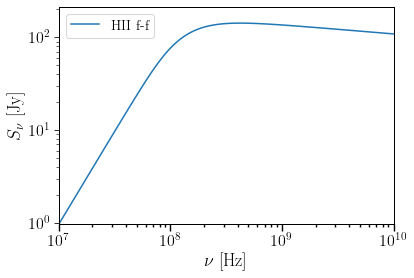

In [4]:
# Simple check of the S_ff function:
R_s = 1e17
D = 1e21
T_e = 1e4
n = 1e3
nu = np.geomspace( 1e7, 1e10, 100)
S = S_ff(nu, R_s, D, T_e, n)

# Plot data and fit
fig, ax = plt.subplots(1)
plt.gca().set_xlabel(r'$\nu$ [Hz]')
plt.gca().set_ylabel(r'$S_\nu$ [Jy]')
plt.plot(nu, S, label = 'HII f-f')
plt.title('')
plt.xlim(nu[0], nu[-1])
plt.ylim(min(S), 1.5*max(S))

plt.legend(loc='best')
ax.loglog()

In [5]:
# Constants in cgs units 
pc = 3.08567758e18 
kpc = 1e3 * pc 
AU = 1.496e13

## Model for a random system

In [41]:
# System parameters
D = 2.0 * kpc
T_e = 1e4
theta_s = 1.0 #arcsec
R_s = theta_s * (D/pc) * AU  # R_s[AU] = theta_s[arcsec] * D[pc]

# Observations to fit
nu = np.array( [325e6, 735e6, 1260e6, 4.8e9, 8.4e9] ) # in Hz
S = np.array( [1.6, 3.3, 4.0, 3.9, 3.5] )      # in Jy
S_err = np.array( [0.1*flux for flux in S] ) # assume a 10% calibration error


In [42]:
# Model fitting

# Define seed values for the fit
seed = np.array([2]) # log(n)
bs = ((1), (5)) # ( min values, max values ) = ( (min_n, ...), (max_n, ...) )

# Fit function S_ff(nu, R, D, Te, n) to the data  
popt, pcov = curve_fit( lambda x, logn: S_ff(x,R_s,D,T_e,10**logn), xdata=nu, ydata=S, p0=seed, sigma=S_err, bounds=bs, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
    
n = ufloat(10**popt[0], 10**popt[0] * perr[0]) # I fit log(n), so the error delta(logn) = (delta n)/n

print(f'Density: {n = :.2u}')

# prepare confidence level curves
nstd = 1.0 # to draw 1-sigma intervals
popt_up = popt + nstd * perr
popt_dw = popt - nstd * perr

nu_fit = np.geomspace( min(nu)/1.5, max(nu)*5., 100)
fit = S_ff(nu_fit, R_s,D,T_e, n.nominal_value)
fit_up = S_ff(nu_fit, R_s,D,T_e, 10**popt_up[0])
fit_dw = S_ff(nu_fit, R_s,D,T_e, 10**popt_dw[0])


Density: n = 6586+/-77


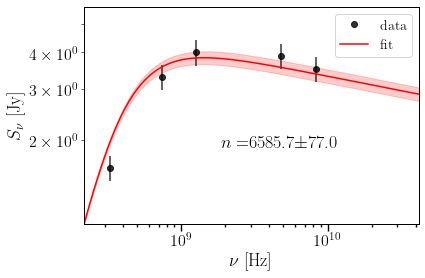

In [43]:
# Plot data and fit

fig, ax = plt.subplots(1)
plt.gca().set_xlabel(r'$\nu$ [Hz]')
plt.gca().set_ylabel(r'$S_\nu$ [Jy]')
plt.errorbar(nu, S, yerr=S_err, ecolor='k', alpha=0.8, fmt='none')
plt.plot(nu, S, 'ko', alpha=0.8, label = 'data')
plt.plot(nu_fit, fit, 'r-', label='fit')
ax.fill_between(nu_fit, fit_up, fit_dw, alpha=.2, label='', color='r')
plt.title('')
plt.xlim(nu_fit[0], nu_fit[-1])
plt.ylim(min(fit), 1.5*max(fit))

plt.legend(loc='best')
ax.loglog()
ax.annotate(r'$n =$' + str(round(abs(n.nominal_value),1)) + '$\pm$' + str(round(n.std_dev,1)),
            xy=(0.35, 0.25), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom')

plt.show()